# Proyecto ML

## Wikipedia Movie Plots

Importa las librarías que se usaran

In [146]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import re
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

np.warnings.filterwarnings('ignore')

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

import tensorflow as tf
import tensorflow.compat.v1 as tfv1
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.ERROR)

from tqdm import tqdm_notebook as tqdm

plt.style.use('ggplot')
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

Carga los datos (se pueden bajar de aquí: https://www.kaggle.com/jrobischon/wikipedia-movie-plots)

In [147]:
wiki_plots = pd.read_csv("wiki_movie_plots_deduped.csv")
wiki_plots.rename(columns={'Origin/Ethnicity':'Origin'}, inplace=True) # para mayor comodidad
wiki_plots = wiki_plots.drop_duplicates(subset='Plot', keep='first')
wiki_plots.shape

(33869, 8)

Muestra de los primeros datos

In [0]:
df.head(3)

,Release Year,Title,Origin,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."


### Descripción de las columnas

La base de datos contiene descripciones para 34,886 películas de todo el mundo. las columnas son las siguientes:

- Release Year - Año en que se estreno la película
- Title - Titulo de la película
- Origin/Ethnicity - Origen de la pelicula (e.g. America, Bollywood, Tamil, etc)
- Director - Director(s)
- Cast - Actores y actrices principales
- Genre - Genero(s) de la película
- Wiki Page - URL de la pagina de Wikipedia de la cual la descripción de la trama fue tomada
- Plot - descripción larga de la trama de la película (ADVERTENCIA: puede contener espoilers)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33869 entries, 0 to 34885
Data columns (total 8 columns):
Release Year    33869 non-null int64
Title           33869 non-null object
Origin          33869 non-null object
Director        33869 non-null object
Cast            32554 non-null object
Genre           33869 non-null object
Wiki Page       33869 non-null object
Plot            33869 non-null object
dtypes: int64(1), object(7)
memory usage: 2.3+ MB


In [0]:
df.describe()

,Release Year
count,33869.000000
mean,1980.968555
std,27.851760
min,1901.000000
25%,1956.000000
50%,1988.000000
75%,2006.000000
max,2017.000000


## Graficas

### Países de origen de las pelícuals

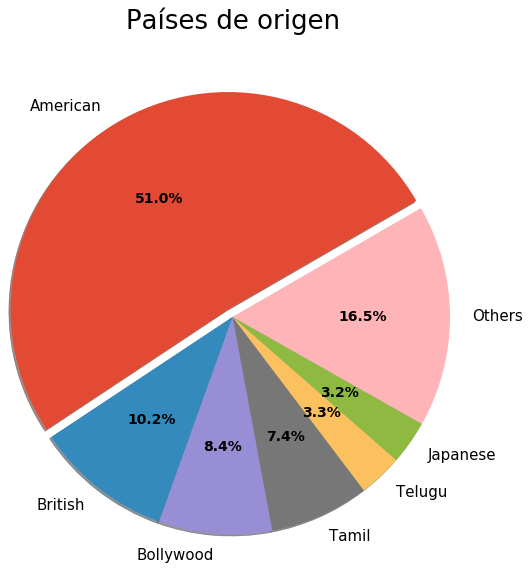

In [0]:
fig, ax = plt.subplots()
_, texts, autotexts = ax.pie(list(df['Origin'].value_counts()[:6].values) + [sum(df['Origin'].value_counts()[6:])], 
                    explode=(0.1, 0, 0, 0, 0, 0, 0), 
                    labels=list(df['Origin'].value_counts()[:6].index) + ["Others"], 
                    autopct='%1.1f%%',
                    shadow=True, radius=2.5, 
                    startangle=30)

ax.set_title('Países de origen', fontsize=26, loc="center",  y=1.8)
plt.setp(texts, size=15)
plt.setp(autotexts, size=14, weight="bold")
print()

### Número de películas por año

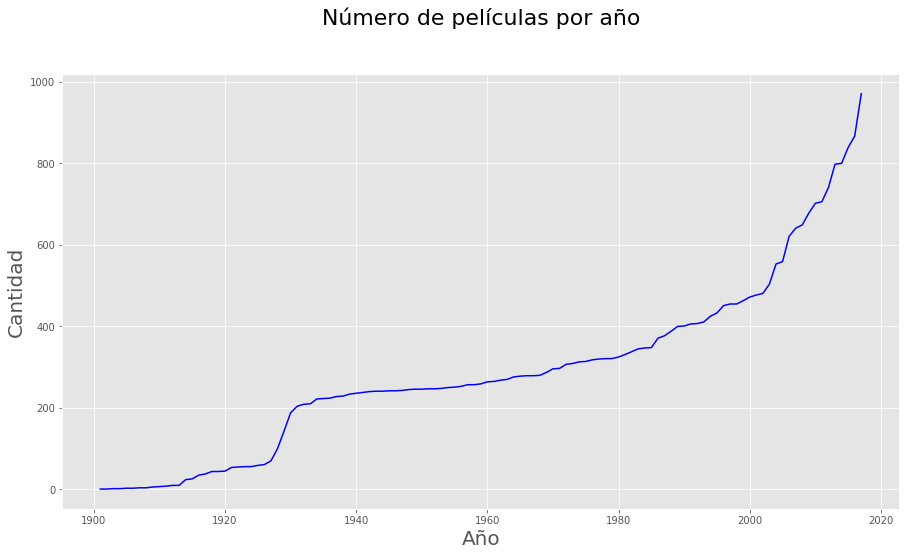

In [0]:
plt.figure(figsize=(15,8))
plt.title('Número de películas por año', fontsize=22, y=1.1)
plt.xlabel('Año', fontsize=20)
plt.ylabel('Cantidad', fontsize=20)
ax = plt.plot(df['Release Year'].unique()[::-1], df['Release Year'].value_counts(), 'b-')

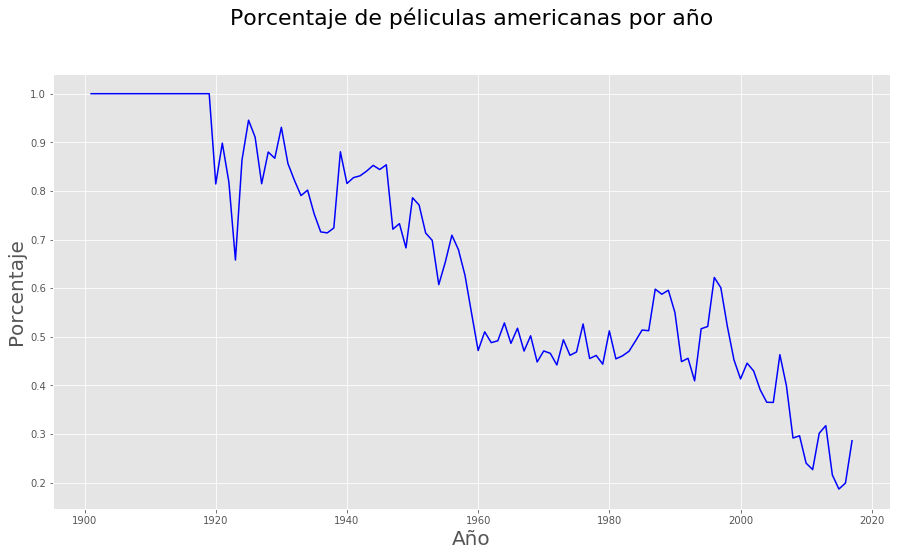

In [0]:
american_movies = df.query('Origin == "American"')['Release Year'].value_counts()
anywhere_movies = df['Release Year'].value_counts()

percentages = american_movies.divide(anywhere_movies)

plt.figure(figsize=(15,8))
plt.title('Porcentaje de péliculas americanas por año', fontsize=22, y=1.1)
plt.xlabel('Año', fontsize=20)
plt.ylabel('Porcentaje', fontsize=20)
ax = plt.plot(df['Release Year'].unique()[::-1], percentages[::-1], 'b-')

Géneros

In [0]:
len(df['Genre'].unique())

2192

Text(0, 0.5, 'Número de ocurrencias')

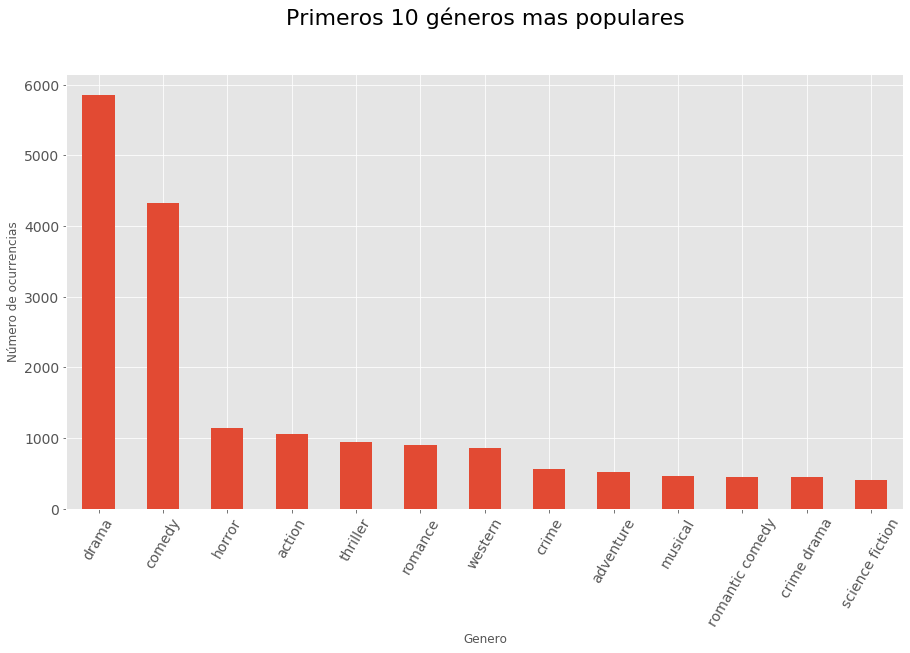

In [0]:
Genre = df.query('Genre != "unknown"')['Genre'].value_counts()
ax = Genre[:13].plot(kind='bar', figsize=(15,8), fontsize=14)
ax.set_title('Primeros 10 géneros mas populares', size=22, y=1.1)
plt.xticks(rotation=60)
plt.xlabel('Genero')
plt.ylabel('Número de ocurrencias')

Hay demasiados generos

### Reducción del numero de géneros

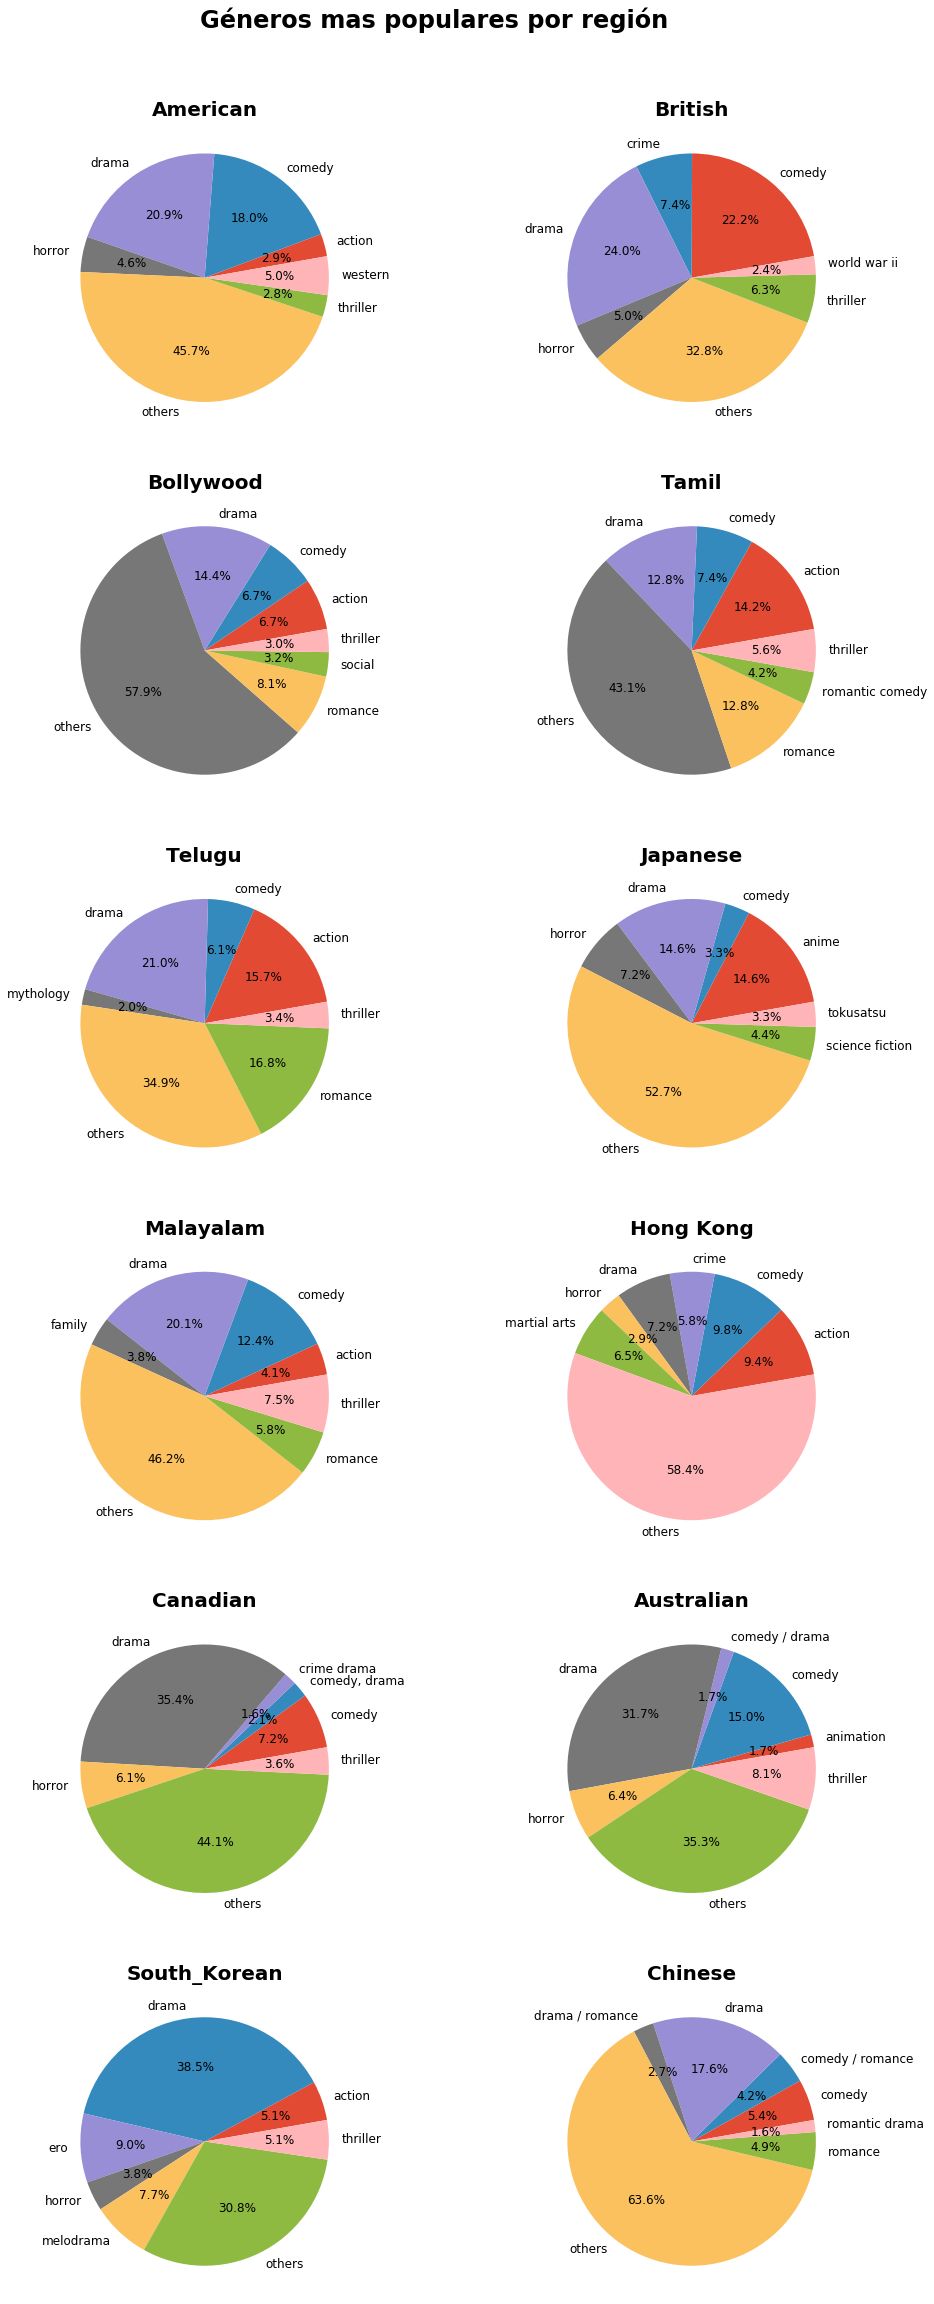

In [0]:
def grouping_func(s, index, splt_index):
    if list(s.index).index(index) > splt_index:
        return 'others'
    return index

fig, axes = plt.subplots(nrows=6, ncols=2)
fig.suptitle("Géneros mas populares por región", fontsize=24, y=0.92, weight="bold")

for i, origin in enumerate(df['Origin'].value_counts().head(12).index):
    populars = df.query(f'(Origin == "{origin}") & (Genre != "unknown")')['Genre'].value_counts()
    populars.groupby(lambda s: grouping_func(populars, s, 5)).sum().plot(ax=axes[i//2,i%2], kind='pie', 
                                                                         fontsize=12, autopct='%1.1f%%', 
                                                                         figsize=(16,40), startangle=10, 
                                                                         label="")
    axes[i//2,i%2].set_title(f"{origin}", fontsize=20, weight="bold")

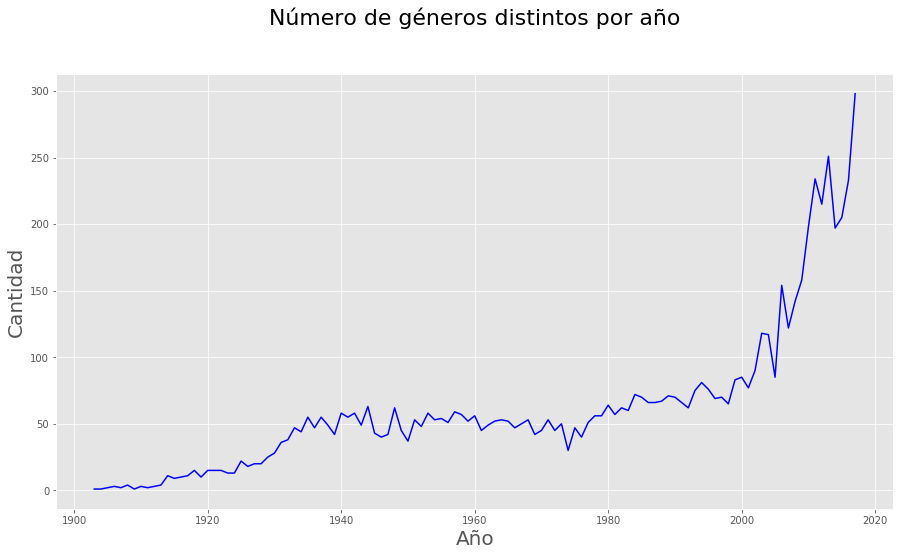

In [0]:
print()
plt.figure(figsize=(15,8))
plt.title('Número de géneros distintos por año', fontsize=22, y=1.1)
plt.xlabel('Año', fontsize=20)
plt.ylabel('Cantidad', fontsize=20)
genres_per_year = df.query('Genre != "unknown"').groupby('Release Year')['Genre'].nunique()
ax = plt.plot(genres_per_year.index,
              genres_per_year, 'b-')

### Algunos ejemplos de tramas

In [0]:
print(f'{df["Title"][342]} - {df["Release Year"][342]}')
print("")
print(df['Plot'][342])

Old Lady 31 - 1920

Based upon a summary of the plot in a review in a film publication,[3] Angie (Dunn) and Abe (Harmon) have been married for many years when bad investments force them to sell their homestead. Angie is to go to the old ladies' home while Abe is to go to live on the poor farm. When the twenty-nine inmates of the old ladies' home see how hard it is for the couple to part, they agree to take Abe in, and he is listed on their roster as "Old Lady 31." There are several comic situations as Abe wins his way into the hearts of his female companions. When some apparently worthless mining stock is found to have some value, the couple are able to return to their home.


In [0]:
print("{} - {}".format(df['Title'][7347],df['Release Year'][7347]))
print("")
print(df['Plot'][7347])

Five Guns to Tombstone - 1960

Young outlaw Billy Wade, determined to reform, is roped into a robbery by rich businessman George Landon, then framed for it. Billy's brother Matt is sprung from prison by Landon on the condition he get Billy to go along with the theft. During a struggle for a gun, Matt is accidentally killed and his teenaged son Ted and others mistakenly believe Billy killed him in cold blood. Billy pretends to help bandit Ike Garvey but ultimately assists in his capture, earning Ted's forgiveness.


In [0]:
print("{} - {}".format(df['Title'][5],df['Release Year'][5]))
print("")
print(df['Plot'][5])

Alice in Wonderland - 1903

Alice follows a large white rabbit down a "Rabbit-hole". She finds a tiny door. When she finds a bottle labeled "Drink me", she does, and shrinks, but not enough to pass through the door. She then eats something labeled "Eat me" and grows larger. She finds a fan when enables her to shrink enough to get into the "Garden" and try to get a "Dog" to play with her. She enters the "White Rabbit's tiny House," but suddenly resumes her normal size. In order to get out, she has to use the "magic fan."
She enters a kitchen, in which there is a cook and a woman holding a baby. She persuades the woman to give her the child and takes the infant outside after the cook starts throwing things around. The baby then turns into a pig and squirms out of her grip. "The Duchess's Cheshire Cat" appears and disappears a couple of times to Alice and directs her to the Mad Hatter's "Mad Tea-Party." After a while, she leaves.
The Queen invites Alice to join the "ROYAL PROCESSION": a p

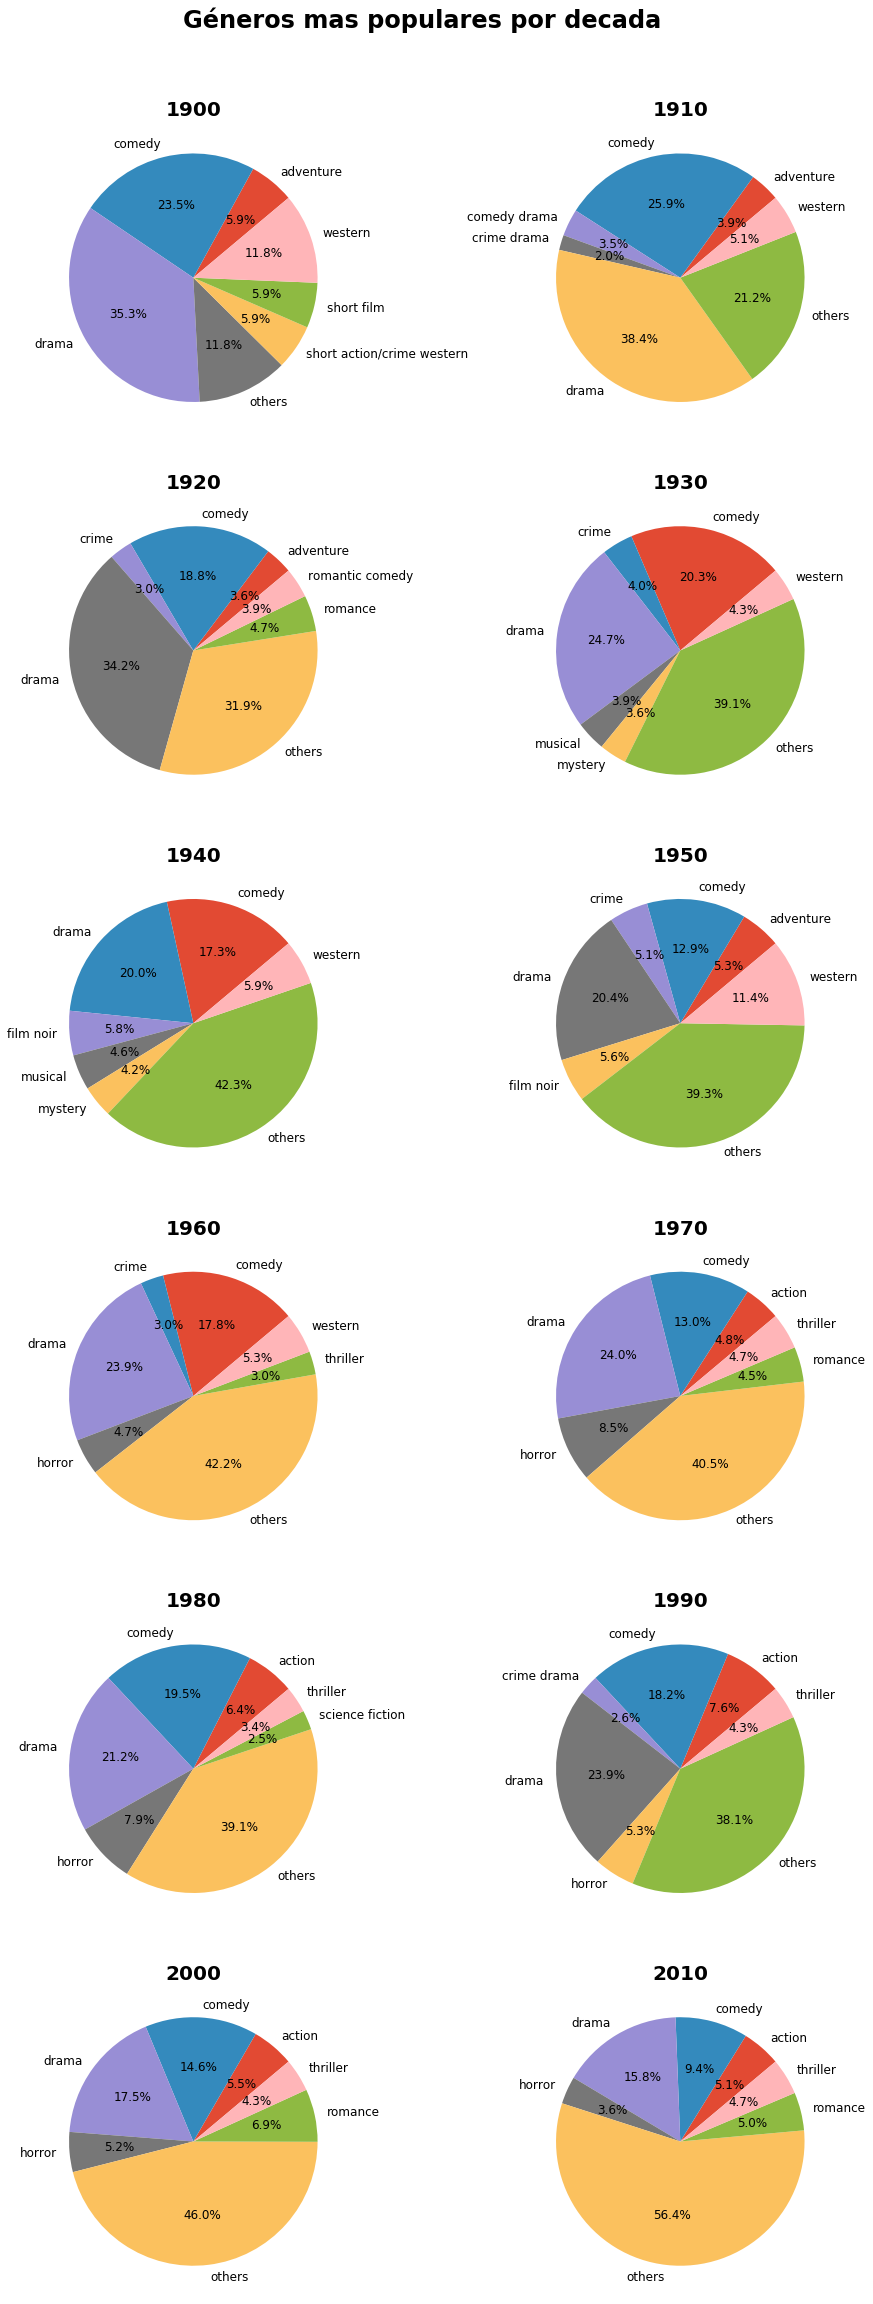

In [0]:
def grouping_func(s, index, splt_index):
    if list(s.index).index(index) > splt_index:
        return 'others'
    return index

fig, axes = plt.subplots(nrows=6, ncols=2)
fig.suptitle("Géneros mas populares por decada", fontsize=24, y=0.92, weight="bold")

for i, decade in enumerate(range(1900,2017,10)):
    populars = df.query(f'`Release Year` >= {decade} & `Release Year` < {decade+10} & Genre != "unknown"')['Genre'].value_counts()
    populars.groupby(lambda s: grouping_func(populars, s, 5)).sum().plot(ax=axes[i//2,i%2], 
                                                                         kind='pie', 
                                                                         fontsize=12, 
                                                                         autopct='%1.1f%%', 
                                                                         figsize=(16,40), 
                                                                         startangle=40, 
                                                                         label="")
    axes[i//2,i%2].set_title(f"{decade}", fontsize=20, weight="bold")

### Formato de los textos

In [0]:
print("{} - {}".format(df['Title'][2454],df['Release Year'][2454]))
print("")
text = df['Plot'][2454]
text

The Sisters - 1938



"At a ball held on the night of the 1904 presidential election, serious Louise, frivolous Helen, and stolid Grace, daughters of Silver Bow, Montana pharmacist Ned Elliott and his wife Rose, find themselves dealing with romantic prospects. Tom Knivel is about to propose to Louise when Frank Medlin, a San Francisco sports reporter, asks her to dance. Infatuated with the young woman, Frank extends his stay, and at Sunday dinner in the Elliott home he announces he and Louise plan to wed. Although her parents disapprove of the union, Louise leaves for San Francisco with Frank that night. Grace eventually marries the jilted Tom and Helen weds wealthy Sam Johnson, who promises her freedom and asks for nothing in return.\r\nAlthough facing financial difficulty, Louise urges Frank to complete his novel. When she becomes pregnant, she decides to keep her condition a secret, but finally reveals the truth when she accompanies Frank to a boxing match and the smoke and smells make her ill. Returning

In [148]:
def clean_text(text):
    """
    This function is taken from:
    https://www.kaggle.com/aminejallouli/genre-classification-based-on-wiki-movies-plots
    """
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", "", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\[\d+\]", "", text)
    text = re.sub('[%s\d]' % re.escape("""!"#$%&'()*+,-.:;<=>?@[\]^`{|}~"""), "", text)
    text = re.sub(r"[-\n]", " ", text)
    text = text.strip(' ')
    return text

# test
print(clean_text(wiki_plots['Plot'][2454]))

 two years pass the city has been rebuilt and louise is an executive in the department store when she learns tom has been unfaithful to grace she returns to silver bow and is reunited with both her sisters meanwhile frank returns to san francisco and although he is ill he travels to silver bow with tim when he learns louise is there at the ball on the night of the  presidential election frank and louise are reunited and decide to give their marriage another chance


In [0]:
wiki_plots['FormattedPlot'] = wiki_plots['Plot'].apply(clean_text)

### Nubes de palabras

Nube de palabras de las tramas en general

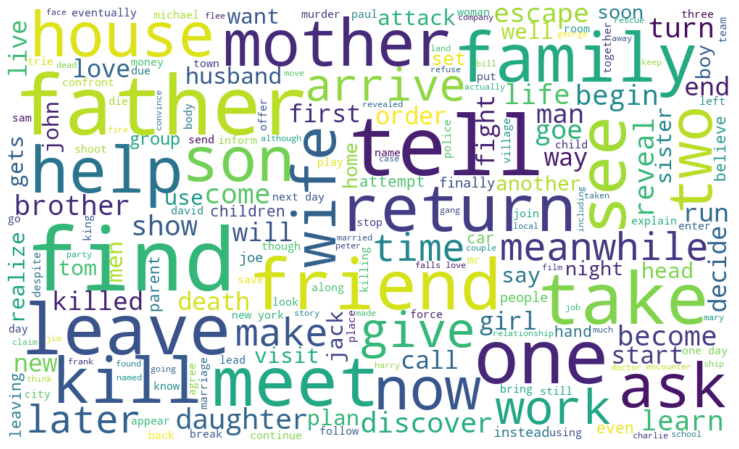

In [0]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      width=1000, 
                      height=600, 
                      max_font_size=120,
                      background_color="white").generate(" ".join(df.FormattedPlot))

plt.subplots(figsize=(18,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Nube de palabras de las tramas por genero

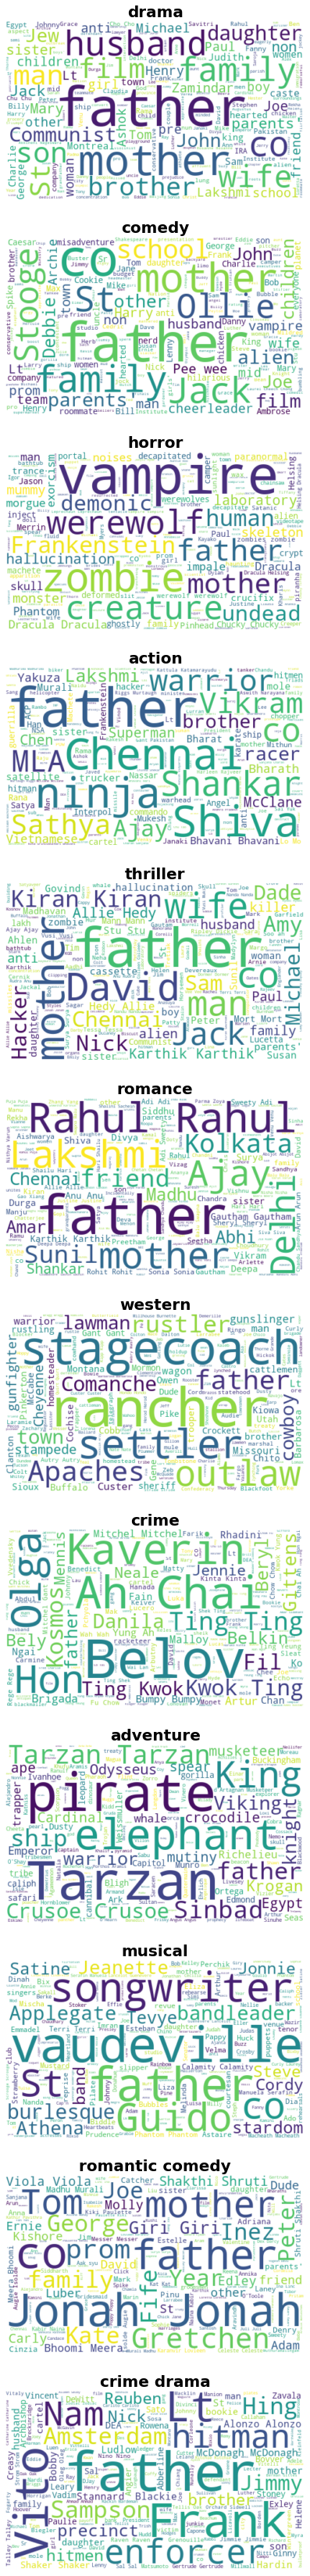

In [0]:
stopwords = set(STOPWORDS)
fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(40,60))
#stopwords.update(['father', 'find', 'tell', 'meet', 'one', 'two', 'later', 'goes', 'take', 'finds', 'leave'])

frequent_words = {}
for i, genre in enumerate(df.query('Genre != "unknown"')['Genre'].value_counts()[:12].index):
    words = list(set(word_tokenize(" ".join(df.query(f'Genre == "{genre}"')['Plot']))))
    for word in words:
        if word in frequent_words:
            frequent_words[word] += 1
        else:
            frequent_words[word] = 1
    
for word in frequent_words.items():
    if word[1] > 7:
        stopwords.add(word[0])

for i, genre in enumerate(df.query('Genre != "unknown"')['Genre'].value_counts()[:12].index):
    wordcloud = WordCloud(stopwords=stopwords,
                          width=500, 
                          height=300, 
                          max_font_size=90,
                          background_color="white").generate(" ".join(df.query(f'Genre == "{genre}"')['Plot']))
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title("{}".format(genre), fontsize=20, weight="bold")
    axes[i].axis('off')

In [0]:
"""
This code is taken from:https://www.kaggle.com/aminejallouli/genre-classification-based-on-wiki-movies-plots
and it's a little bit modified.
"""
wiki_plots['GenreCorrected'] =wiki_plots['Genre'] 
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.strip()
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' - ', '|')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' / ', '|')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('/', '|')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' & ', '|')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(', ', '|')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('; ', '|')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('bio-pic', 'biography')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('biopic', 'biography')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('biographical', 'biography')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('biodrama', 'biography')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('bio-drama', 'biography')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('biographic', 'biography')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' \(film genre\)', '')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('animated','animation')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('anime','animation')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('children\'s','children')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('comedey','comedy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('\[not in citation given\]','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' set 4,000 years ago in the canadian arctic','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('historical','history')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('romantic','romance')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('3-d','animation')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('3d','animation')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('viacom 18 motion pictures','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('sci-fi','science_fiction')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('ttriller','thriller')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('.','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('based on radio serial','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' on the early years of hitler','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('sci fi','science_fiction')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('science fiction','science_fiction')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' (30min)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('16 mm film','short')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('\[140\]','drama')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('\[144\]','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' for ','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('adventures','adventure')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('kung fu','martial_arts')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('kung-fu','martial_arts')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('martial arts','martial_arts')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('world war ii','war')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('world war i','war')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('biography about montreal canadiens star|maurice richard','biography')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('bholenath movies|cinekorn entertainment','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' \(volleyball\)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('spy film','spy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('anthology film','anthology')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('biography fim','biography')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('avant-garde','avant_garde')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('biker film','biker')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('buddy cop','buddy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('buddy film','buddy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('comedy 2-reeler','comedy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('films','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('film','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('biography of pioneering american photographer eadweard muybridge','biography')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('british-german co-production','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('bruceploitation','martial_arts')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('comedy-drama adaptation of the mordecai richler novel','comedy-drama')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('movies by the mob\|knkspl','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('movies','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('movie','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('coming of age','coming_of_age')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('coming-of-age','coming_of_age')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('drama about child soldiers','drama')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('(( based).+)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('(( co-produced).+)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('(( adapted).+)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('(( about).+)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('musical b','musical')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('animationchildren','animation|children')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' period','period')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('drama loosely','drama')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' \(aquatics|swimming\)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' \(aquatics|swimming\)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace("yogesh dattatraya gosavi's directorial debut \[9\]",'')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace("war-time","war")
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace("wartime","war")
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace("ww1","war")
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('unknown','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace("wwii","war")
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('psychological','psycho')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('rom-coms','romance')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('true crime','crime')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('\|007','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('slice of life','slice_of_life')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('computer animation','animation')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('gun fu','martial_arts')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('j-horror','horror')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' \(shogi|chess\)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('afghan war drama','war drama')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('\|6 separate stories','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' \(30min\)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' (road bicycle racing)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' v-cinema','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('tv miniseries','tv_miniseries')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('\|docudrama','\|documentary|drama')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' in animation','|animation')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('((adaptation).+)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('((adaptated).+)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('((adapted).+)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('(( on ).+)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('american football','sports')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('dev\|nusrat jahan','sports')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('television miniseries','tv_miniseries')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' \(artistic\)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' \|direct-to-dvd','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('history dram','history drama')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('martial art','martial_arts')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('psycho thriller,','psycho thriller')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('\|1 girl\|3 suitors','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' \(road bicycle racing\)','')
filterE = wiki_plots['GenreCorrected']=="ero"
wiki_plots.loc[filterE,'GenreCorrected']="adult"
filterE = wiki_plots['GenreCorrected']=="music"
wiki_plots.loc[filterE,'GenreCorrected']="musical"
filterE = wiki_plots['GenreCorrected']=="-"
wiki_plots.loc[filterE,'GenreCorrected']=''
filterE = wiki_plots['GenreCorrected']=="comedy–drama"
wiki_plots.loc[filterE,'GenreCorrected'] = "comedy|drama"
filterE = wiki_plots['GenreCorrected']=="comedy–horror"
wiki_plots.loc[filterE,'GenreCorrected'] = "comedy|horror"
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(' ','|')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace(',','|')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('-','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('actionadventure','action|adventure')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('actioncomedy','action|comedy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('actiondrama','action|drama')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('actionlove','action|love')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('actionmasala','action|masala')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('actionchildren','action|children')

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('fantasychildren\|','fantasy|children')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('fantasycomedy','fantasy|comedy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('fantasyperiod','fantasy|period')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('cbctv_miniseries','tv_miniseries')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('dramacomedy','drama|comedy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('dramacomedysocial','drama|comedy|social')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('dramathriller','drama|thriller')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('comedydrama','comedy|drama')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('dramathriller','drama|thriller')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('comedyhorror','comedy|horror')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('sciencefiction','science_fiction')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('adventurecomedy','adventure|comedy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('animationdrama','animation|drama')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('\|\|','|')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('muslim','religious')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('thriler','thriller')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('crimethriller','crime|thriller')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('fantay','fantasy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('actionthriller','action|thriller')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('comedysocial','comedy|social')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('martialarts','martial_arts')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('\|\(children\|poker\|karuta\)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('epichistory','epic|history')

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('erotica','adult')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('erotic','adult')

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('((\|produced\|).+)','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('chanbara','chambara')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('comedythriller','comedy|thriller')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('biblical','religious')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('biblical','religious')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('colour\|yellow\|productions\|eros\|international','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('\|directtodvd','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('liveaction','live|action')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('melodrama','drama')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('superheroes','superheroe')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('gangsterthriller','gangster|thriller')

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('heistcomedy','comedy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('heist','action')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('historic','history')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('historydisaster','history|disaster')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('warcomedy','war|comedy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('westerncomedy','western|comedy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('ancientcostume','costume')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('computeranimation','animation')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('dramatic','drama')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('familya','family')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('familya','family')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('dramedy','drama|comedy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('dramaa','drama')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('famil\|','family')

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('superheroe','superhero')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('biogtaphy','biography')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('devotionalbiography','devotional|biography')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('docufiction','documentary|fiction')

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('familydrama','family|drama')

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('espionage','spy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('supeheroes','superhero')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('romancefiction','romance|fiction')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('horrorthriller','horror|thriller')

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('suspensethriller','suspense|thriller')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('musicaliography','musical|biography')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('triller','thriller')

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('\|\(fiction\)','|fiction')

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('romanceaction','romance|action')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('romancecomedy','romance|comedy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('romancehorror','romance|horror')

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('romcom','romance|comedy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('rom\|com','romance|comedy')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('satirical','satire')

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('science_fictionchildren','science_fiction|children')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('homosexual','adult')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('sexual','adult')

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('mockumentary','documentary')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('periodic','period')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('romanctic','romantic')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('politics','political')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('samurai','martial_arts')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('tv_miniseries','series')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('serial','series')

filterE = wiki_plots['GenreCorrected']=="musical–comedy"
wiki_plots.loc[filterE,'GenreCorrected'] = "musical|comedy"

filterE = wiki_plots['GenreCorrected']=="roman|porno"
wiki_plots.loc[filterE,'GenreCorrected'] = "adult"


filterE = wiki_plots['GenreCorrected']=="action—masala"
wiki_plots.loc[filterE,'GenreCorrected'] = "action|masala"


filterE = wiki_plots['GenreCorrected']=="horror–thriller"
wiki_plots.loc[filterE,'GenreCorrected'] = "horror|thriller"

#wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('family','children')
#wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('martial_arts','action')
#wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('horror','thriller')
#wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('war','action')
#wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('adventure','action')
#wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('science_fiction','action')
#wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('western','action')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('noir','black')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('spy','action')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('superhero','action')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('social','')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('suspense','thriller')


filterE = wiki_plots['GenreCorrected']=="drama|romance|adult|children"
wiki_plots.loc[filterE,'GenreCorrected'] = "drama|romance|adult"

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('\|–\|','|')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.strip(to_strip='\|')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('actionner','action')
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.strip()

def merge_similar(gn):
    gn_list = gn.split('|')
    gn_list = sorted(list(set(gn_list)))
    return '|'.join(gn_list)

wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].apply(merge_similar)
wiki_plots['GenreCorrected']=wiki_plots['GenreCorrected'].str.replace('^$','unknown')

In [0]:
wiki_plots['GenreSplit'] = wiki_plots['GenreCorrected'].str.split('|')
wiki_plots['GenreSplit'] = wiki_plots['GenreSplit'].apply(np.array)

In [152]:
genres = [genre for sublist in wiki_plots['GenreSplit'].values for genre in sublist]
genres = pd.DataFrame({'Counts':genres})['Counts'].value_counts().to_frame().reset_index().rename(columns={'index':'Genre'})
genres = genres[genres['Genre'] != 'unknown'].head(23)
genres = np.array(genres['Genre'])
genres

array(['drama', 'comedy', 'romance', 'action', 'thriller', 'crime',
       'horror', 'western', 'musical', 'science_fiction', 'animation',
       'adventure', 'family', 'war', 'fantasy', 'mystery', 'biography',
       'black', 'history', 'short', 'martial_arts', 'documentary',
       'sports'], dtype=object)

In [0]:
wiki_plots['GenreSplit'] = wiki_plots['GenreSplit'].apply(lambda x: x[np.in1d(x, genres)])

In [154]:
dummy_clases = wiki_plots.query('GenreCorrected != "unknown"')['GenreSplit'].apply(lambda x: '|'.join(x)).str.get_dummies()
dummy_clases['drama'].values

array([0, 0, 0, ..., 0, 0, 0])

## Entrenando un clasificador (varios)

In [0]:
data = wiki_plots.query('GenreCorrected != "unknown"').reset_index()

X_train, X_test, y_train, y_test = train_test_split(data['FormattedPlot'].values, dummy_clases)

stemmer = WordNetLemmatizer()
for i in range(len(X_train)):
    X_train[i] = [stemmer.lemmatize(word) for word in X_train[i].split(' ')]
    X_train[i] = ' '.join(X_train[i])
    
for i in range(len(X_test)):
    X_test[i] = [stemmer.lemmatize(word) for word in X_test[i].split(' ')]
    X_test[i] = ' '.join(X_test[i])

tfidf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, stop_words='english')
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test).toarray()

In [0]:
def train_clasifiers(x, y, clases):
    clasifiers = []
    for c in clases:
        clf = OneVsRestClassifier(LinearSVC(random_state=0, max_iter=25000))
        clf.fit(x, y[c].values)
        clasifiers.append(clf)
    return clasifiers

def predict(clasifiers, x, clases):
    pred_clases = []
    for i, clf in enumerate(clasifiers):
        if clf.predict([x])[0] == 1:
            pred_clases.append(clases[i])
    return pred_clases

def predict_vector(clf, X):
    pred = np.zeros((len(X)))
    for i, x in enumerate(X):
        pred[i] = clf.predict([x])[0]
    return pred

def evalueate_models(clasifiers, X_test, y_test, clases):
    score = np.zeros((len(clases)))
    for i, c in enumerate(clases):
        score[i] = accuracy_score(predict_vector(clasifiers[i], X_test), y_test[c].values)
    return score

In [0]:
clasifiers = train_clasifiers(X_train, y_train, genres)

In [260]:
i = 2003
print(data['Title'][i])
print(data['GenreSplit'][i])
print(predict(clasifiers, X_test[i], genres))

Fury
['crime' 'drama']
['comedy']


In [261]:
acc = evalueate_models(clasifiers, X_test, y_test, genres)
print(np.mean(acc))

0.9539609117289615


## Sistema de recomendación de peliculas similares

Función para codificar las tramas en vectores densos de 512

In [0]:
def get_embeddings(tokenized_sents):
    embed_list = []
    with tfv1.Graph().as_default():
        print("Downloading the model")
        embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")
        print("Processing plots")
        messages = tfv1.placeholder(dtype=tf.string, shape=[None])
        embed_list = []
        embedding = embed(messages)
        embedding_mean = tfv1.math.reduce_mean(embedding, axis=0)
        normalized_embedding = tfv1.nn.l2_normalize(embedding_mean, 0)
        with tfv1.Session() as session:
            session.run([tfv1.global_variables_initializer(), tfv1.tables_initializer()])
            for sent in tqdm(tokenized_sents):
                output = session.run(embedding_mean, feed_dict={messages: sent})
                # this is slow
                # encoded_plot = session.run(tfv1.math.reduce_mean(output, axis=0))
                embed_list.append(output.reshape(-1,1))
    return embed_list

In [158]:
print("Tokenizig sentences in the plots")
tokenized_sents = []
for movie_plot in tqdm(wiki_plots['FormattedPlot']):
    sent = sent_tokenize(movie_plot)
    tokenized_sents.append(sent)

embed_list = get_embeddings(tokenized_sents)

Tokenizig sentences in the plots


Processing plots


In [0]:
wiki_plots['EmbeddingPlot'] = embed_list

Busquedad de peliculas similares en base de la trama codigicada

In [0]:
def get_similar_movies(embedding_plot, embeddings, titles, min_similarity=0.5):
    similar_movies = []
    embeddings = np.array(embeddings.tolist()).squeeze()
    with tfv1.Session() as session:
        vec1 = tfv1.placeholder(dtype=tf.float32, shape=(None, 512), name="vec1")
        vec2 = tfv1.placeholder(dtype=tf.float32, shape=(512, 1), name="vec2")

        cos_similarity = tf.matmul(vec1, vec2)

        similarities = session.run(cos_similarity, feed_dict={vec1: embeddings, vec2: embedding_plot})
        similarities = [x for x in zip(similarities, titles) if x[0] > min_similarity]
        similarities.sort(key=lambda x: x[0], reverse=True)
        similarities.pop(0)
        similar_movies = [title for (_, title) in similarities]
    return similar_movies

In [0]:
df['Title'] = df['Title'].str.replace('\"', '')

In [0]:
embed_plot = df.query('Title == "The Chronicles of Narnia: The Lion, the Witch and the Wardrobe"').iloc[0]['EmbeddingPlot']
print(get_similar_movies(embed_plot, df['EmbeddingPlot'].values, df['Title'], min_similarity=0.8))

['Troll', 'Jack the Giant Killer', 'The Witches', 'Hansel & Gretel: Witch Hunters', "Happily N'Ever After", 'Inkheart', 'Snow White & the Huntsman', 'The Devil Rides Out', 'The Raven', 'Hocus Pocus', 'The Wizard of Oz', 'A Simple Wish', 'Mirror Mirror', 'The Chronicles of Narnia: Prince Caspian', 'Just Visiting', 'Howling II', 'The Spiderwick Chronicles', 'Tom Thumb', 'The Chronicles of Narnia: The Voyage of the Dawn Treader', 'The Wicker Man', 'The Swan Princess', 'The Maze', 'Cry of the Banshee', 'Pan', 'The Brothers Grimm', 'Peter Pan', 'Snow White and the Three Stooges', 'Leprechaun: Origins', 'The City of the Dead', 'The Vampire Lovers', "Mary and the Witch's Flower", 'The Haunted Palace', 'Black Cauldron, The', 'Happily Ever After', 'Dracula: Prince of Darkness', 'Lesbian Vampire Killers', 'Sleeping Beauty', 'Snow White: A Tale of Terror', ' Ella Enchanted', 'The Swan Princess Christmas']


In [0]:
movie_lens = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [161]:
movie_lens.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [162]:
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


In [163]:
clear_title = lambda x: re.sub(r' \(\d{4}\)', '', x)
movie_lens['title'] = movie_lens['title'].apply(clear_title)
movie_lens.head(10)

,movieId,title,genres
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji,Adventure|Children|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy
5,6,Heat,Action|Crime|Thriller
6,7,Sabrina,Comedy|Romance
7,8,Tom and Huck,Adventure|Children
8,9,Sudden Death,Action
9,10,GoldenEye,Action|Adventure|Thriller


In [164]:
in_wiki_plots = lambda x: (wiki_plots.Title == x).any()
movie_lens['InWikiPlots'] = movie_lens['title'].apply(in_wiki_plots)
movie_lens[movie_lens.InWikiPlots == True].count()

movieId        4891
title          4891
genres         4891
InWikiPlots    4891
dtype: int64

In [165]:
movie_lens_reduced = movie_lens[movie_lens.InWikiPlots == True]
movie_lens_reduced.head(10)

,movieId,title,genres,InWikiPlots
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,True
1,2,Jumanji,Adventure|Children|Fantasy,True
2,3,Grumpier Old Men,Comedy|Romance,True
3,4,Waiting to Exhale,Comedy|Drama|Romance,True
4,5,Father of the Bride Part II,Comedy,True
5,6,Heat,Action|Crime|Thriller,True
6,7,Sabrina,Comedy|Romance,True
7,8,Tom and Huck,Adventure|Children,True
8,9,Sudden Death,Action,True
9,10,GoldenEye,Action|Adventure|Thriller,True


In [166]:
valid_rating = lambda x: (movie_lens_reduced.movieId == x).any()
ratings['valid'] = ratings['movieId'].apply(valid_rating)
ratings_reduced = ratings[ratings.valid == True]
len(ratings_reduced)

64169

In [167]:
def get_embeddings(id):
    title = movie_lens_reduced[movie_lens_reduced.movieId == id]['title'].iloc[0]
    return np.array(wiki_plots.query(f'Title == "{title}"')['EmbeddingPlot'].iloc[0].tolist()).squeeze()

ratings_reduced['embeddings'] = ratings_reduced['movieId'].apply(get_embeddings)
ratings_reduced.head(10)

,userId,movieId,rating,timestamp,valid,embeddings
0,1,1,4.0,964982703,True,"[0.0077550518326461315, 0.011775807477533817, ..."
1,1,3,4.0,964981247,True,"[-0.031014366075396538, 0.02753722295165062, -..."
2,1,6,4.0,964982224,True,"[0.04757323116064072, 0.06013210490345955, -0...."
5,1,70,3.0,964982400,True,"[-0.04830478876829147, -0.0365079827606678, -0..."
6,1,101,5.0,964980868,True,"[-0.04517536610364914, -0.03670736029744148, -..."
7,1,110,4.0,964982176,True,"[-0.008381982333958149, -0.05141633749008179, ..."
8,1,151,5.0,964984041,True,"[0.022778308019042015, -0.0427921898663044, 0...."
9,1,157,5.0,964984100,True,"[-0.04360337555408478, -0.008092694915831089, ..."
10,1,163,5.0,964983650,True,"[-0.036191973835229874, -0.04408616945147514, ..."
11,1,216,5.0,964981208,True,"[0.0186429675668478, 0.05028223618865013, 0.00..."


In [0]:
norm_indices = lambda index: index - 1
ratings_reduced['userIdNorm'] = ratings_reduced['userId'].apply(norm_indices)
ratings_reduced['movieIdNorm'] = ratings_reduced['movieId'].apply(norm_indices)

In [169]:
batch_size = 64
r_train, r_test = train_test_split(ratings_reduced, train_size=0.8)
print(r_train.shape)
r_train_batches = np.split(r_train, [batch_size] * r_train.shape[0], axis=0)

(51335, 8)


In [0]:
u = len(ratings_reduced['userIdNorm'].unique())
m = len(r_train['embeddings'])

In [255]:
saver = tf.train.Saver()

def feed(U, V, indices):
    gathered_u = tf.gather(U, indices=indices)
    return tf.reduce_sum(tf.multiply(gathered_u, V), axis=1)

U = tf.Variable(tf.random_normal([u, 512]), dtype=tf.float32, name="weights")
V = tfv1.placeholder(dtype=tf.float32, shape=(None, 512))
lmbda = tf.constant(0.00005)
#gathered_u = tf.gather(U, r_train['userIdNorm'].values, name="gathered_u")
pred = feed(U, V, r_train['userIdNorm'].values)
regularizer = tf.nn.l2_loss(U)
regularizer = tf.multiply(lmbda, regularizer)
loss = tf.add(tf.losses.mean_squared_error(r_train['rating'].values, pred), regularizer)
optimizer = tf.train.AdamOptimizer(learning_rate=0.02)
step = optimizer.minimize(loss)

input_embeds = np.array(r_train['embeddings'].tolist())
error = 0

with tfv1.Session() as session:
    session.run([tfv1.global_variables_initializer(), tfv1.local_variables_initializer()])
    print("Comenzando el entrenamiento")
    for epoch in tqdm(range(100)):
        _, error = session.run([step, loss], feed_dict={V: input_embeds})
    saver.save(session, "weights")
print(f"final loss is {error}")


Comenzando el entrenamiento


final loss is 2.5488474369049072


In [256]:
pred = feed(U, V, r_test['userIdNorm'].values)
test_loss = tf.losses.mean_squared_error(r_test['rating'].values, pred)
with tfv1.Session() as session:
    session.run([tfv1.global_variables_initializer(), tfv1.local_variables_initializer()])
    saver.restore(session, "weights")
    error = session.run(test_loss, feed_dict={V: np.array(r_test['embeddings'].tolist())})
    print(f"Test error: {error}")

Test error: 13.918868064880371
